<a href="https://colab.research.google.com/github/ThatNinjaGuy/Machine-learning-A-Z-Course/blob/develop/resume_analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pdfplumber

In [2]:
!pip install sklearn-crfsuite

In [3]:
!pip install flask-ngrok

In [4]:
!pip install pyngrok

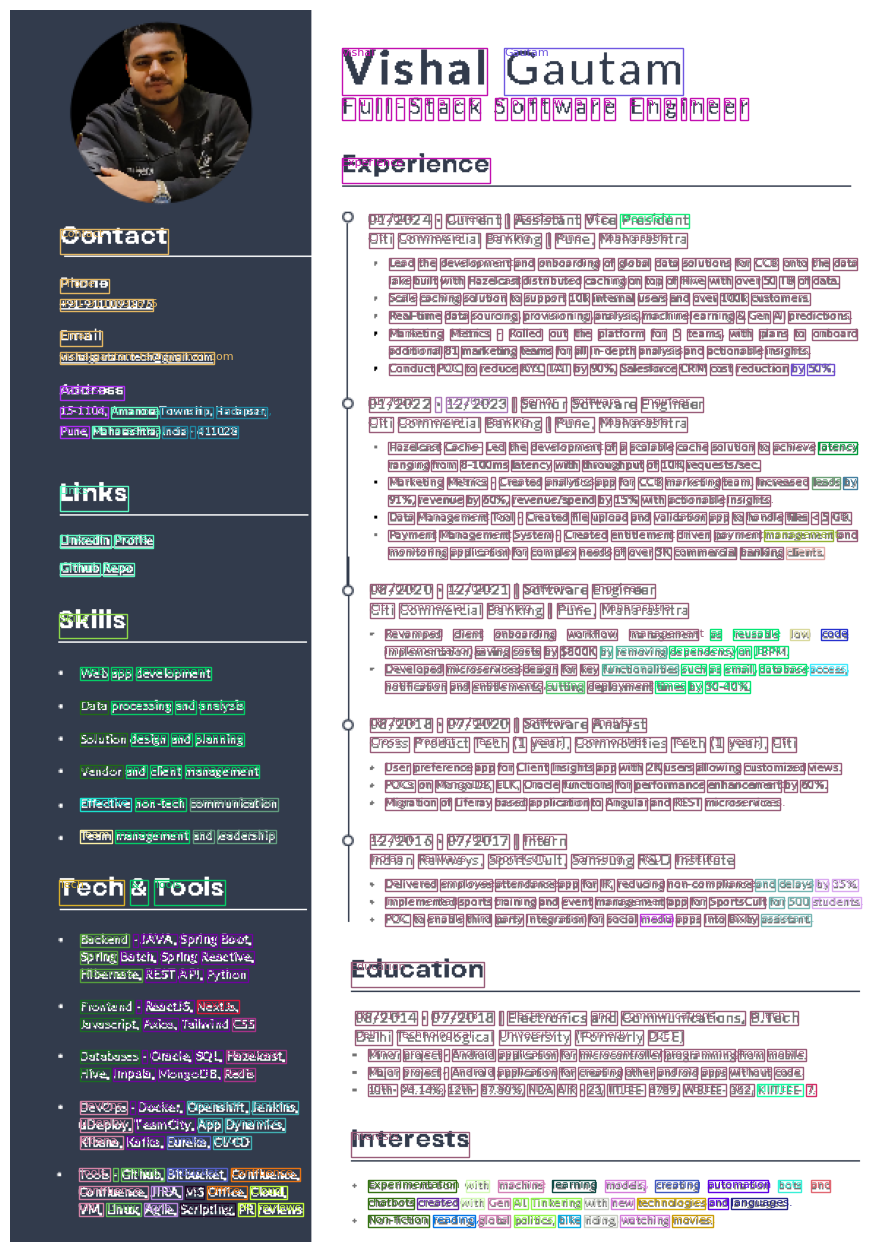

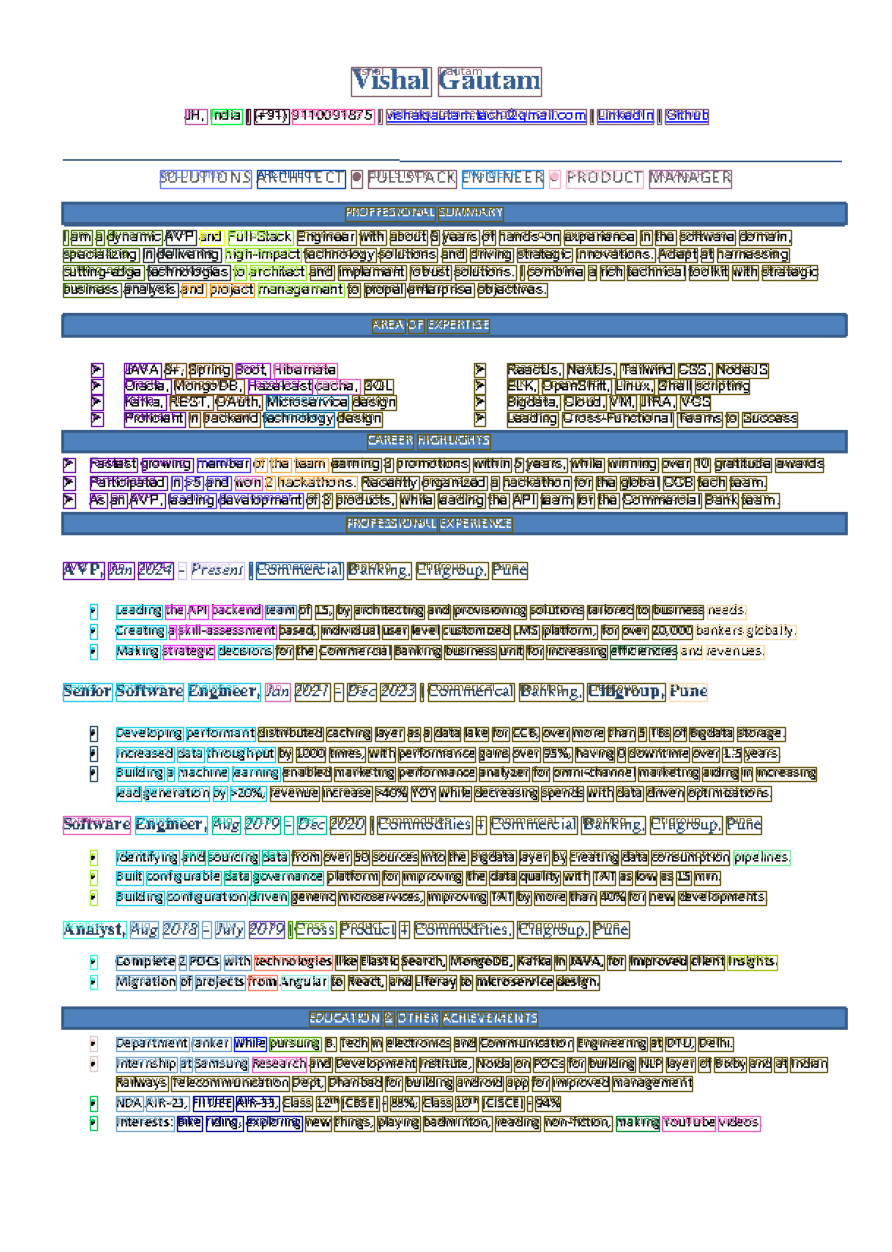

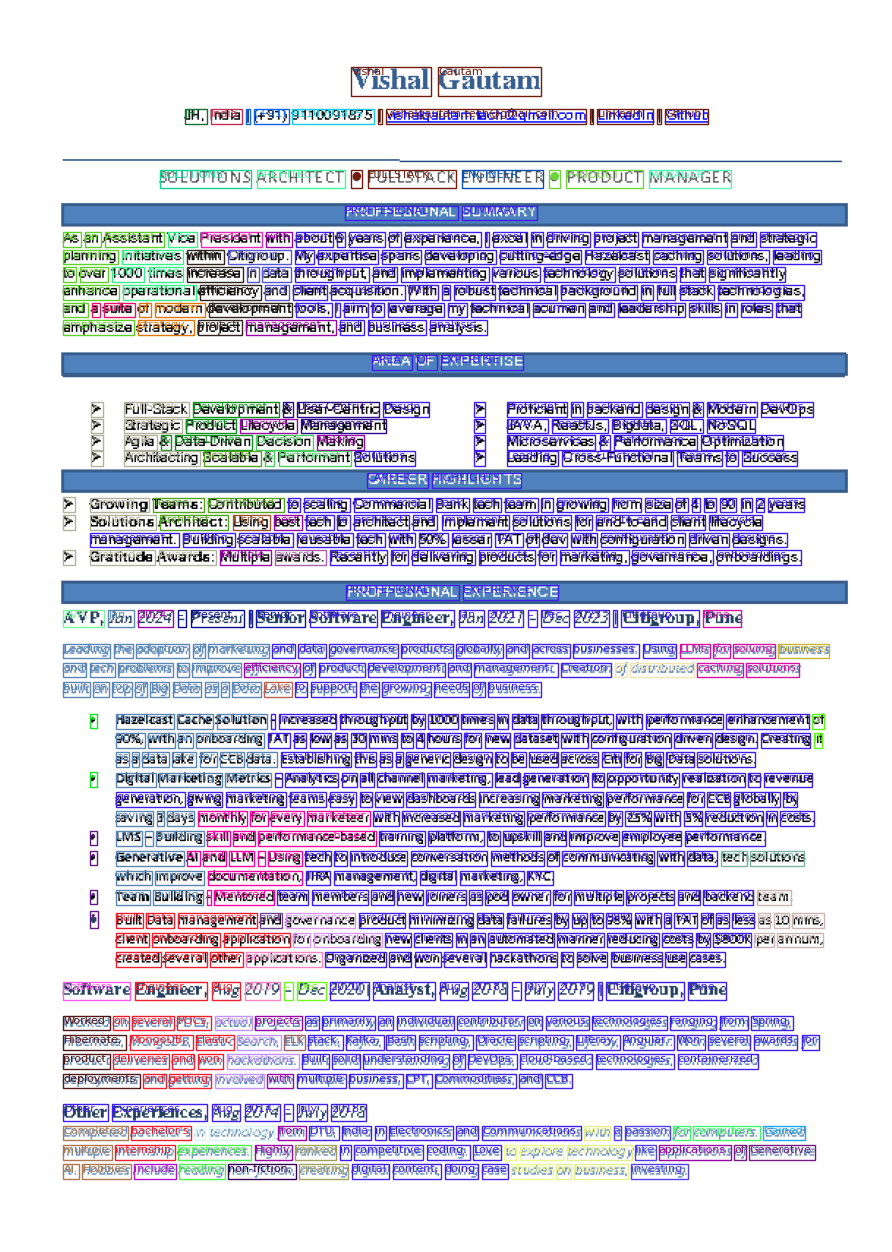

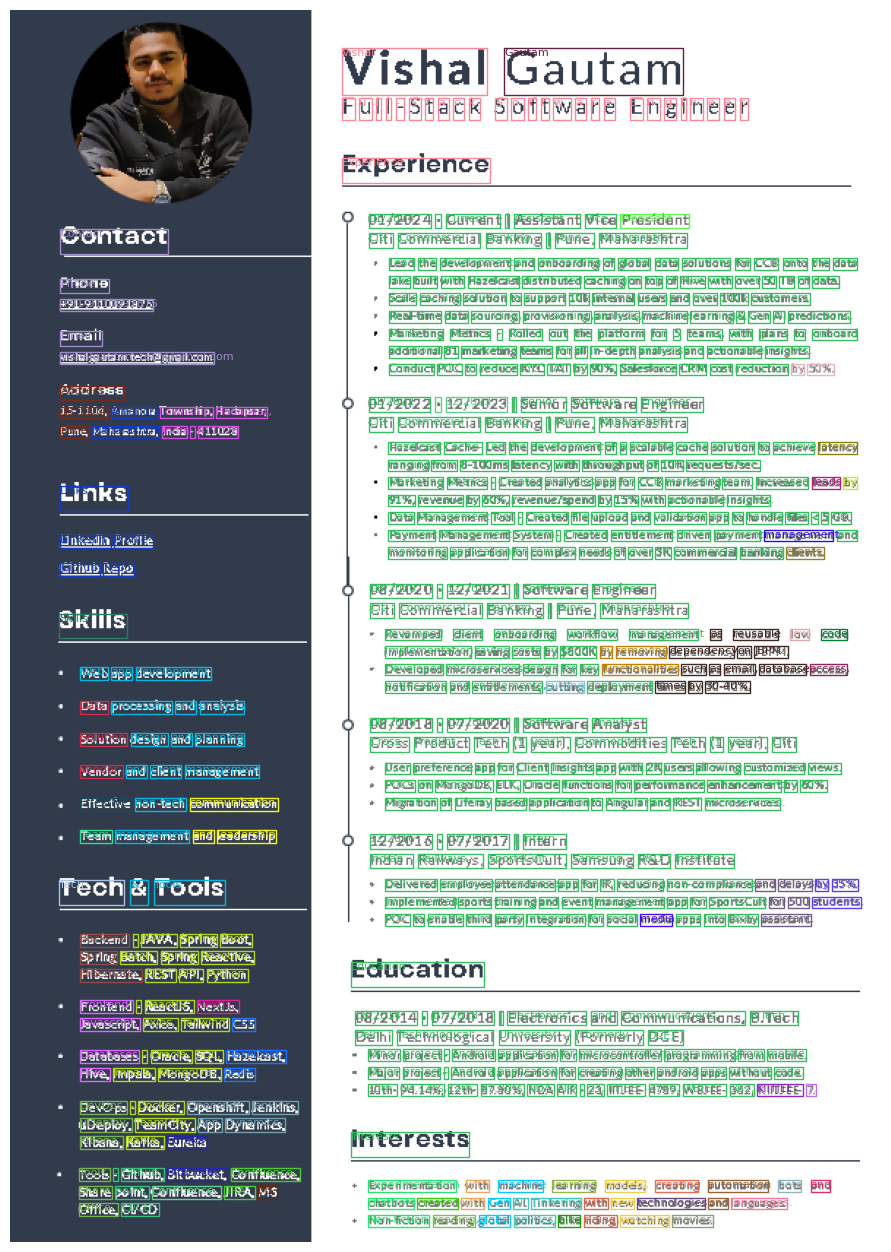

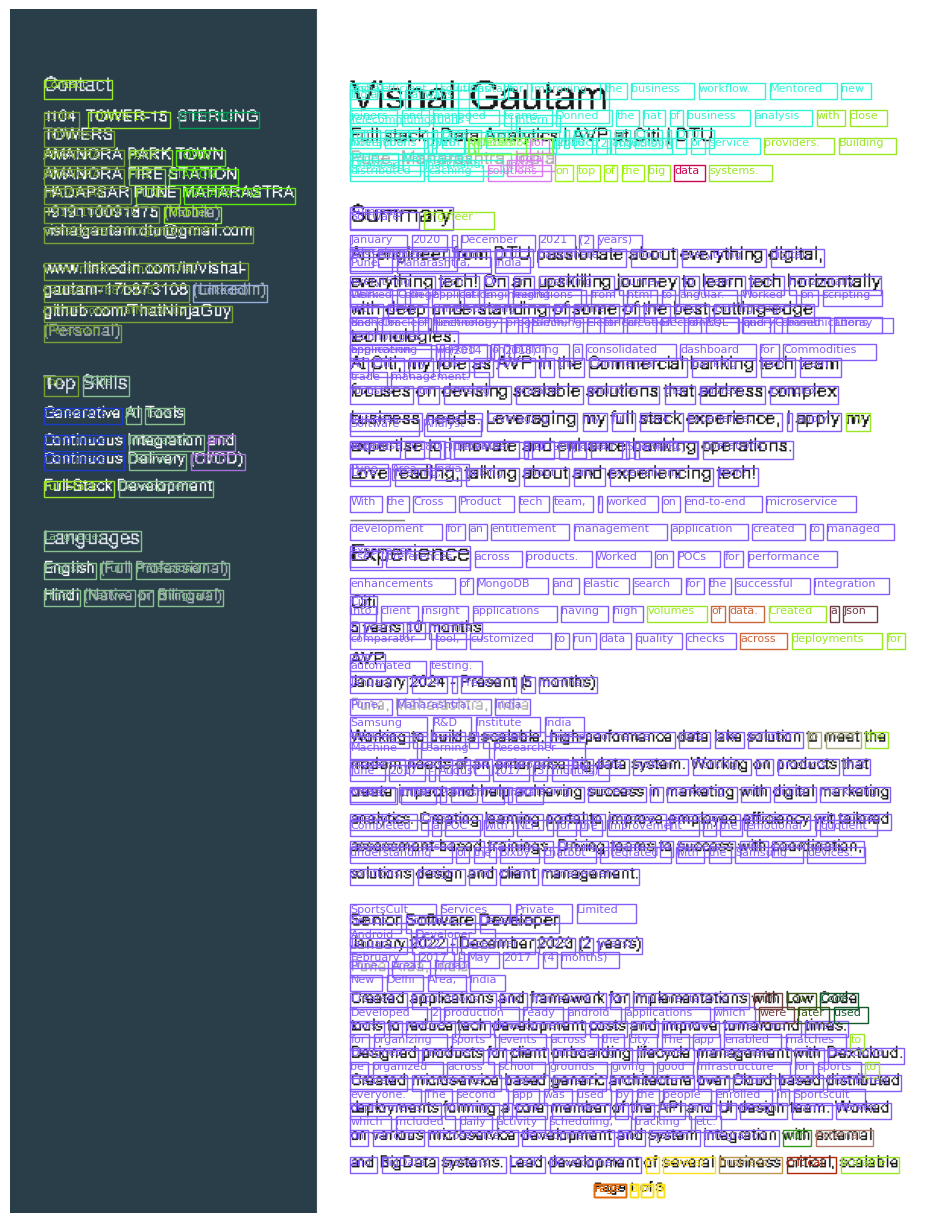

In [6]:
import os
import pdfplumber
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.cluster import DBSCAN
import pandas as pd
import sklearn_crfsuite
from sklearn_crfsuite import metrics

# Function to extract text with positional information using pdfplumber
def extract_text_with_positions(file_path):
    text_elements = []
    with pdfplumber.open(file_path) as pdf:
        for page in pdf.pages:
            for obj in page.extract_words():
                text_elements.append({
                    'text': obj['text'],
                    'x0': obj['x0'],
                    'top': obj['top'],
                    'x1': obj['x1'],
                    'bottom': obj['bottom'],
                    'page_number': page.page_number
                })
    return text_elements

def process_resume(file_path):
    text_elements = extract_text_with_positions(file_path)
    return text_elements

# Create features for clustering
def create_features(text_elements):
    features = []
    for elem in text_elements:
        feature = {
            'x0': elem['x0'],
            'top': elem['top'],
            'width': elem['x1'] - elem['x0'],
            'height': elem['bottom'] - elem['top'],
            'page_number': elem['page_number']
        }
        features.append(feature)
    return features

# Convert features to string format required by pycrfsuite
def convert_to_crf_format(features):
    crf_features = []
    for feature in features:
        crf_feature = {
            'x0': str(feature['x0']),
            'top': str(feature['top']),
            'width': str(feature['width']),
            'height': str(feature['height']),
            'page_number': str(feature['page_number'])
        }
        crf_features.append(crf_feature)
    return crf_features

# Train the model (This should be done once with the annotated training data)
def train_model(X_train_crf, y_train_str):
    # Define the CRF model
    crf = sklearn_crfsuite.CRF(
        algorithm='lbfgs',
        c1=0.1,
        c2=0.1,
        max_iterations=100,
        all_possible_transitions=True
    )

    # Train the model
    crf.fit(X_train_crf, y_train_str)
    return crf

# Visualize the identified sections on the resume
def visualize_sections(file_path, text_elements, labels):
    with pdfplumber.open(file_path) as pdf:
        page = pdf.pages[0]
        im = page.to_image()

        label_colors = {}
        for label in set(labels):
            label_colors[label] = tuple(np.random.rand(3))

        fig, ax = plt.subplots(figsize=(12, 16))
        ax.imshow(im.original)

        for elem, label in zip(text_elements, labels):
            x0, top, x1, bottom = elem['x0'], elem['top'], elem['x1'], elem['bottom']
            rect = Rectangle((x0, top), x1 - x0, bottom - top, linewidth=1, edgecolor=label_colors[label], facecolor='none')
            ax.add_patch(rect)
            ax.text(x0, top, elem['text'], fontsize=8, verticalalignment='top', color=label_colors[label])

        plt.axis('off')
        plt.show()

# Directory containing your resume PDFs
directory = '/content/resumes'

# Load and process the training data
all_text_elements = []
for filename in os.listdir(directory):
    if filename.endswith(".pdf"):
        file_path = os.path.join(directory, filename)
        text_elements = process_resume(file_path)
        all_text_elements.extend(text_elements)

# Prepare training data
features = create_features(all_text_elements)
X_train = [features]
labels = DBSCAN(eps=15, min_samples=2).fit(np.array([[f['x0'], f['top']] for f in features])).labels_
y_train = [labels]  # Labels need to be prepared based on your annotation

# Convert features and labels to string format required by pycrfsuite
X_train_crf = [convert_to_crf_format(f) for f in X_train]
y_train_str = [[str(label) for label in labels] for labels in y_train]

# Train the model
crf = train_model(X_train_crf, y_train_str)

# Process and visualize each resume separately
for filename in os.listdir(directory):
    if filename.endswith(".pdf"):
        file_path = os.path.join(directory, filename)
        text_elements = process_resume(file_path)
        features = create_features(text_elements)
        crf_features = convert_to_crf_format(features)
        labels = crf.predict([crf_features])[0]
        visualize_sections(file_path, text_elements, labels)
